In [2]:
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
# importamos deepcopy para copiar objetos
from copy import deepcopy

# cargamos las imagenes:
def load_images(filenames):
    return [imageio.imread(filename) for filename in filenames]

def find_centers(images):
    centers = [cv2.findCirclesGrid(image, (5, 4), None) for image in images]

    return centers

def show_centers(images, centers):
    # mostramos una matriz con las 23 imagenes y los centros encontrados
    images2 = deepcopy(images)
    tmp = [cv2.drawChessboardCorners(img, (5,4), cor[1], cor[0]) for img, cor in zip(images2, centers) if cor[0]]
    # now we show the images in a matrix, 4x6
    fig, ax = plt.subplots(4, 6, figsize=(20, 10))
    for i, image in enumerate(images2):
        ax[i//6, i%6].imshow(image)
        ax[i//6, i%6].axis('off')
        # ponemos el numero de la imagen
        ax[i//6, i%6].set_title(f'Image {i+1}')
    plt.show()
    return images2


def get_circle_centers(chessboard_shape, dx, dy):
    return [[(i%chessboard_shape[0])*dx, (i//chessboard_shape[0])*dy, 0] for i in range(np.prod(chessboard_shape))]


def calibrate():
    
    # cargamos las imagenes
    filenames = [f'calibracion/img{i}.jpg' for i in range(1,24)]
    images = load_images(filenames)

    centers = find_centers(images)

    images2 = show_centers(images, centers)

    # centers:
    valid_centers = [cor[1] for cor in centers if cor[0]]
    num_valid_images = len(valid_centers)

    # obtain their real points
    real_points = get_circle_centers((5, 4), 20, 20)
    real_points = np.asarray([real_points for i in range(num_valid_images)], dtype=np.float32)

    # We are going to convert our coordinates list in the reference system to numpy array
    object_points = np.asarray([real_points for i in range(num_valid_images)], dtype=np.float32)

    # convert the corners list to array
    image_points = np.asarray(valid_centers, dtype=np.float32)

    # now we calibrate the camera
    rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(real_points, image_points, images[0].shape[:2], None, None)

    extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

    print('Calibration matrix:')
    print('-------------------')
    print('Intrinsic parameters:')
    print(intrinsics, '\n')
    print('Distortion coefficients:')
    print(dist_coeffs, '\n')
    # print('Extrinsic parameters:')
    # print(extrinsics, '\n')
    print('RMS:')
    print(rms, '\n')

    return intrinsics, dist_coeffs, extrinsics, real_points, image_points




In [5]:
# Ahora corregimos la distorsion de las imagenes

def undistort(intrinsics, dist_coeffs):
    # cargamos las imagenes
    filenames = [f'calibracion/img{i}.jpg' for i in range(1,24)]
    images = load_images(filenames)

    # ahora corregimos la distorsion de las imagenes
    images_undistorted = [cv2.undistort(image, intrinsics, dist_coeffs) for image in images]

    # mostramos las imagenes antigua y nueva una al lado de la otra
    fig, ax = plt.subplots(4, 6, figsize=(20, 10))
    for i, image in enumerate(images_undistorted):
        
        original = images[i]
        ax[i//6, i%6].imshow(np.hstack((original, image)))
        ax[i//6, i%6].axis('off')
        # ponemos el numero de la imagen
        ax[i//6, i%6].set_title(f'Image {i+1}')
    plt.show()

/var/folders/11/8n3x035j1rngnz1l98ysm7vm0000gn/T/ipykernel_88990/3584443914.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


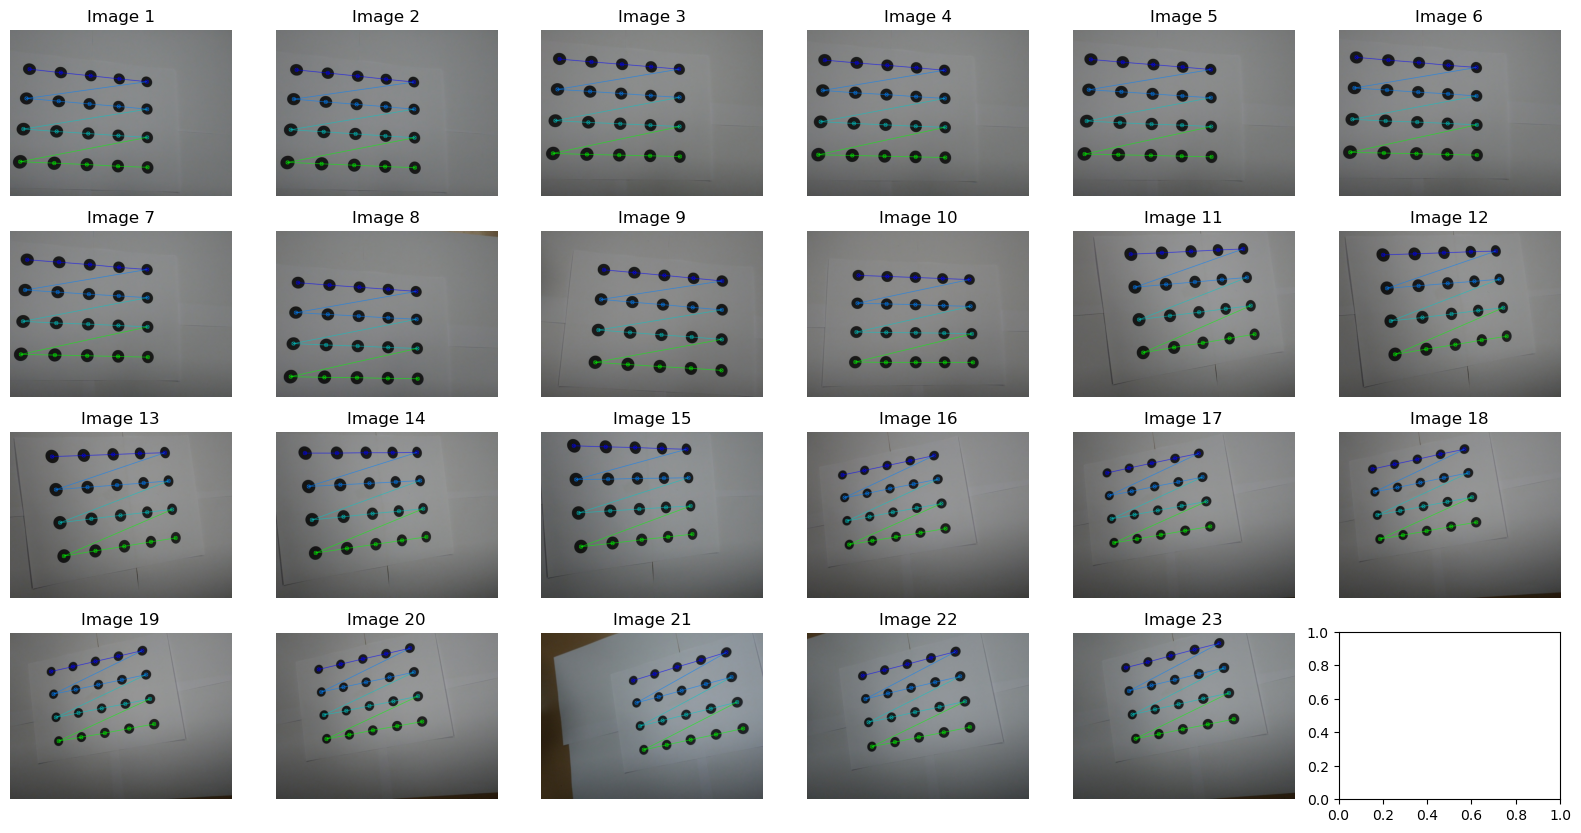

Calibration matrix:
-------------------
Intrinsic parameters:
[[963.99000049   0.         315.69719588]
 [  0.         961.31983307 228.85835581]
 [  0.           0.           1.        ]] 

Distortion coefficients:
[[ 6.94492612e-02 -8.56240698e-01 -1.86174421e-03 -3.81191727e-03
   4.92245679e+00]] 

RMS:
0.1989979308762485 



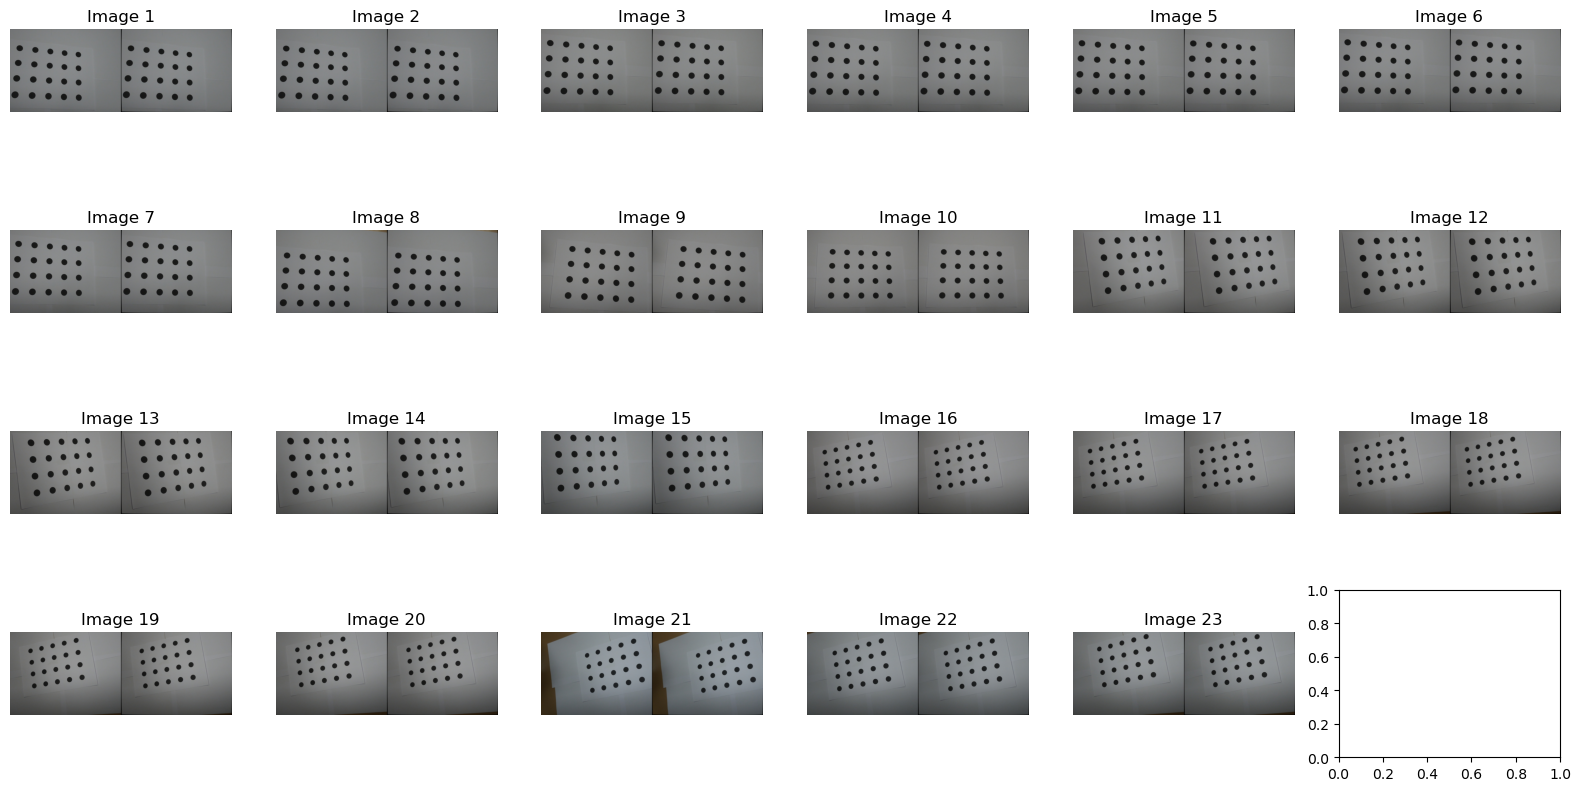

In [6]:
if __name__ == '__main__':
    intrinsics, dist_coeffs, extrinsics, real_points, image_points = calibrate()
    undistort(intrinsics, dist_coeffs)